In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper as hlpr
import re
import warnings

%matplotlib inline

In [2]:
sns.set_style('white')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_json('../data/data_analysis.json')

In [4]:
df.head(200)

,address,category_code,city,headcount,name,phone,revenue,state,time_in_business,zip
0,10085 SCRIPPS RANCH CT STE A,44420000,SAN DIEGO,50 to 99,AMD CUSTOM,3123628000,$20 to 50 Million,CA,10+ years,92131
1,2566 SHALLOWFORD RD NE STE 104 # 302,31490000,ATLANTA,1 to 4,Real Hope Real Estate Inc,None,"Less Than $500,000",GA,10+ years,30345
2,212 E MAIN ST,53120000,NEOSHO,1 to 4,Jimmy Sexton Photography,4046331779,"Less Than $500,000",MO,10+ years,64850
3,6032 CHEROKEE DR,54000000,CINCINNATI,1 to 4,YOU'RE ART,4174513798,"Less Than $500,000",OH,10+ years,45243
4,1315 N WOOSTER AVE,54100000,STRASBURG,1 to 4,Hayberg Restoration Network LLC,5135612584,"$500,000 to $1 Million",OH,10+ years,44680
5,1521 AZALEA RD,23610000,MOBILE,5 to 9,Venzon Engineering,None,$2.5 to 5 Million,AL,6-10 years,36693
6,23513 PLAYVIEW ST,54100000,SAINT CLAIR SHORES,1 to 4,Sunrise Solutions Inc,4082621271,$1 to 2.5 Million,MI,10+ years,48082
7,178 BOOTHBAY RD,23611600,EDGECOMB,1 to 4,Discount Hauling LLC,None,"Less Than $500,000",ME,10+ years,04556
8,7 HAZZARD ST,56000000,WEST PALM BEACH,1 to 4,Knight Equestrian Books,None,"Less Than $500,000",FL,10+ years,33406
9,8054 DARROW RD STE 3,45100000,TWINSBURG,10 to 19,CHILDRENS HOSPITAL PHYS. ASSOC.,2078825494,"Less Than $500,000",OH,None,44087


# EDA

In [5]:
fill_rate = df.notnull().sum()

irrelevant_entries = ['None', 'none', 'null', '', ' ','0',0]
hlpr.replace_bad_entries(df,irrelevant_entries, repl_with=-1, fillna_with=-1)

tv_fill_rate = (df>-1).sum(axis=0)

cardinality = df.apply(hlpr.unique_counter)  #lowercases all strings and removes spaces before checking uniqueness

pd.DataFrame([fill_rate,tv_fill_rate,cardinality],index=['Fill_Rate','True_Value_Fill_Rate','Cardinality']).T

All null and irrelevant entries updated to -1


,Fill_Rate,True_Value_Fill_Rate,Cardinality
address,999986,999898,892035
category_code,999986,999910,1178
city,999986,999895,13615
headcount,962352,962273,9
name,999986,999910,872918
phone,590889,590798,575148
revenue,943092,943001,11
state,999986,999896,53
time_in_business,916125,916048,5
zip,999988,999890,26391


## Downloaded Latitudes and Longitudes for the Zipcodes
* Obtained permission from Radius to join this additional data
* Data obtained from https://www.aggdata.com/node/86 in a csv
* Lost 120 records that didn't match real zipcodes. Still have close to 1 million records so we're fine

In [6]:
zipcodes = pd.read_csv('../supp_data/us_postal_codes.csv')

In [7]:
df.zip = pd.to_numeric(df.zip)
big_df = df.join(zipcodes.set_index('Zip Code'),how='inner',on='zip')  
# Lost 120 records that didn't match real zipcodes. Still have close to 1 million records

## Filled 209 missing values by cross referencing zipcodes dataset
* 105 entries in the City field
* 104 entries in the State field

In [8]:
df['city'][df.city==-1] = big_df['Place Name'].loc[df['city'][df.city==-1].index]
df['state'][df.state==-1] = big_df['State.1'].loc[df['state'][df.state==-1].index]

## Histograms of Time_in_business, Revenue and Headcount

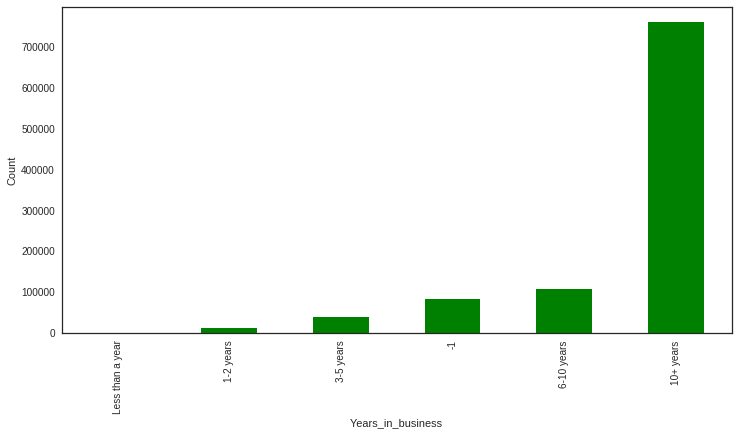

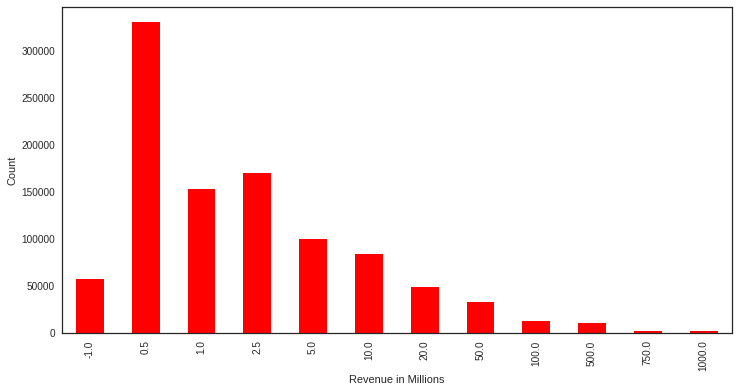

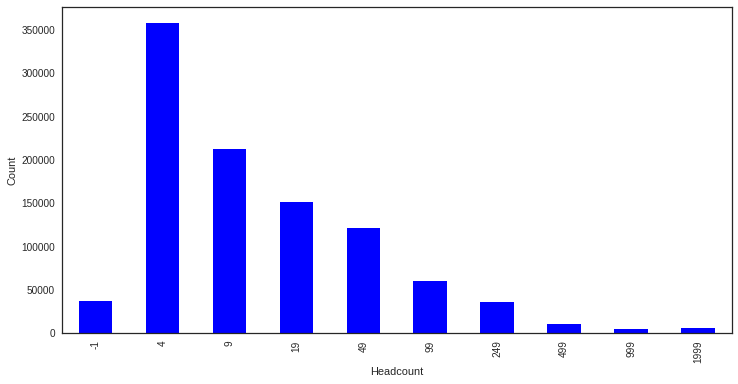

In [9]:
hlpr.numerize_rth(big_df)
plt.xlabel('Years_in_business'); plt.ylabel('Count');  
_ = big_df.time_in_business.value_counts().sort_values().plot(kind='bar',color='g',figsize=(12,6)); plt.show()

plt.xlabel('Revenue in Millions'); plt.ylabel('Count');  
_ = big_df.rev_n.value_counts().sort_index().plot(kind='bar',color='r',figsize=(12,6)); plt.show()

plt.xlabel('Headcount'); plt.ylabel('Count');
_ = big_df.hdcnt_n.value_counts().sort_index().plot(kind='bar',color='b',figsize=(12,6)); plt.show()

## No linear correlation between Headcount, time_in_business and Revenue by themselves
* Tried finding linear correlation between their interactions as well but no signal yet
* Location (ZipCodes) will be critical in untangling this relationship

In [33]:
cols = ['time_n', 'rev_n', 'hdcnt_n', 'hdcnt_n**2', 'hdcnt_n * rev_n', 'hdcnt_n * time_n', 'rev_n * time_n']
hlpr.show_correlations(big_df,cols)

,time_n,rev_n,hdcnt_n,hdcnt_n**2,hdcnt_n * rev_n,hdcnt_n * time_n,rev_n * time_n
time_n,1.000000,-0.000348,-0.000752,-0.001727,0.001028,0.047711,0.033242
rev_n,-0.000348,1.000000,-0.000218,0.000058,0.264528,-0.000007,0.985508
hdcnt_n,-0.000752,-0.000218,1.000000,0.928108,0.189008,0.983894,-0.000015


## Spatial distribution of businesses
* Observe US outline with specs in Hawaii and Alaska
* The Eastern half of the US has a higher density of businesses compared to the Western half. The Western coastline is an exception

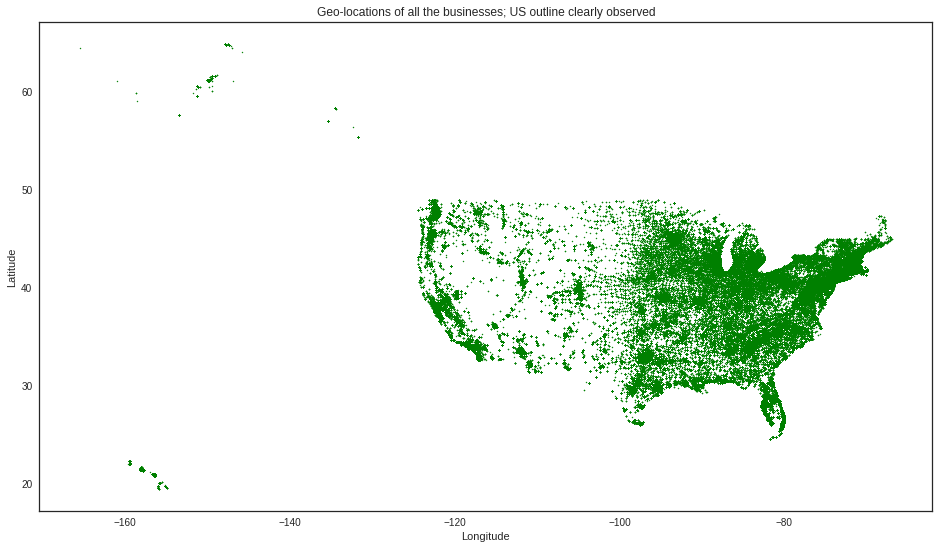

In [34]:
plt.figure(figsize=(16,9)); plt.xlabel('Longitude'),plt.ylabel('Latitude'); plt.title('Geo-locations of all the businesses; US outline clearly observed')
_ = plt.scatter(big_df['Longitude'],big_df['Latitude'],c='g',s=1.2)

## Showing revenue levels via color scheme
* High Revenue businesses (pink) perfectly coincide with major cities in the US, which makes sense
* Businesses seem to emanate outward from the cities
* Revenue tiers also get lower as you move outward from the cities
* Every pink hotspot (revenues over \$100M) is surrounded by green hotspots, which means wherever there's a high-revenue business, there are many more mid-range revenue businesses
* The northeast megalopolis, also known as the Boston-Washington corridor, is clearly visible at the top of the East coast, marked by a slanted pink line
    * This region accounts for 20% of the United States GDP
    * The Headquarters of 162 of the Fortune 500 companies are located here
    * It is the center of the global hedge fund industry
    * Academically, the region is home to six of the eight Ivy League universities

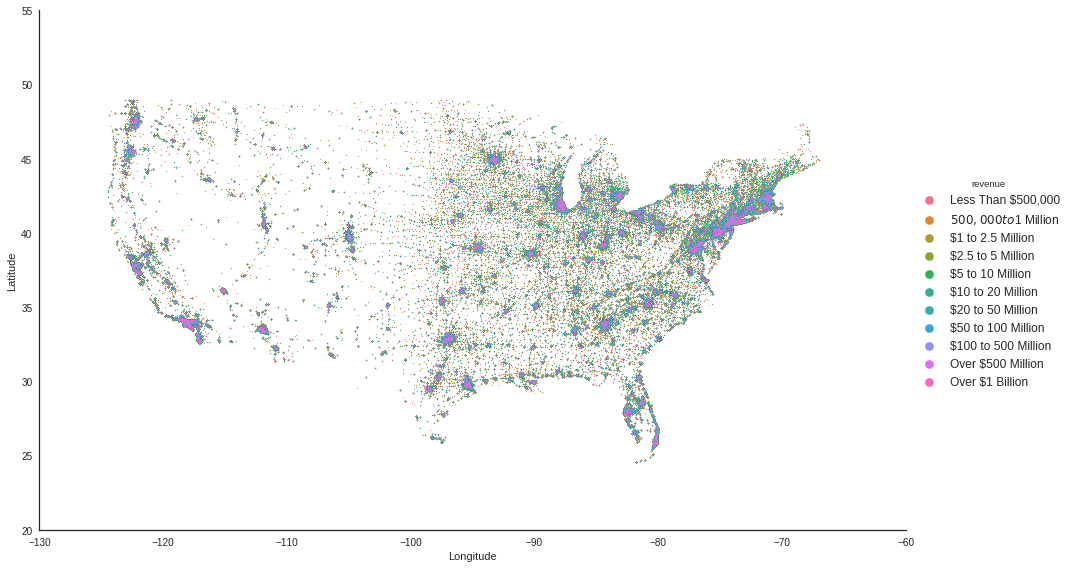

In [35]:
color_column = 'revenue'
data = big_df[big_df.revenue>-1][['Latitude','Longitude',color_column]]
rev_order = ['Less Than $500,000', '$500,000 to $1 Million', '$1 to 2.5 Million',
             '$2.5 to 5 Million', '$5 to 10 Million', '$10 to 20 Million', '$20 to 50 Million',
             '$50 to 100 Million', '$100 to 500 Million', 'Over $500 Million', 'Over $1 Billion']
fg = sns.FacetGrid(data=data, hue=color_column, hue_order=rev_order,size=8, aspect=1.61,xlim=(-130,-60),ylim=(20,55))
_ = fg.map(plt.scatter, 'Longitude', 'Latitude',s=0.7).add_legend(fontsize='large',markerscale=10.0)

## Image showing major US cities (for reference with above plot)
* Image source: http://static2.businessinsider.com/image/53f382f16da811ef6bdf4a43-1200-858/liberal-conservative-city-politics-map.png

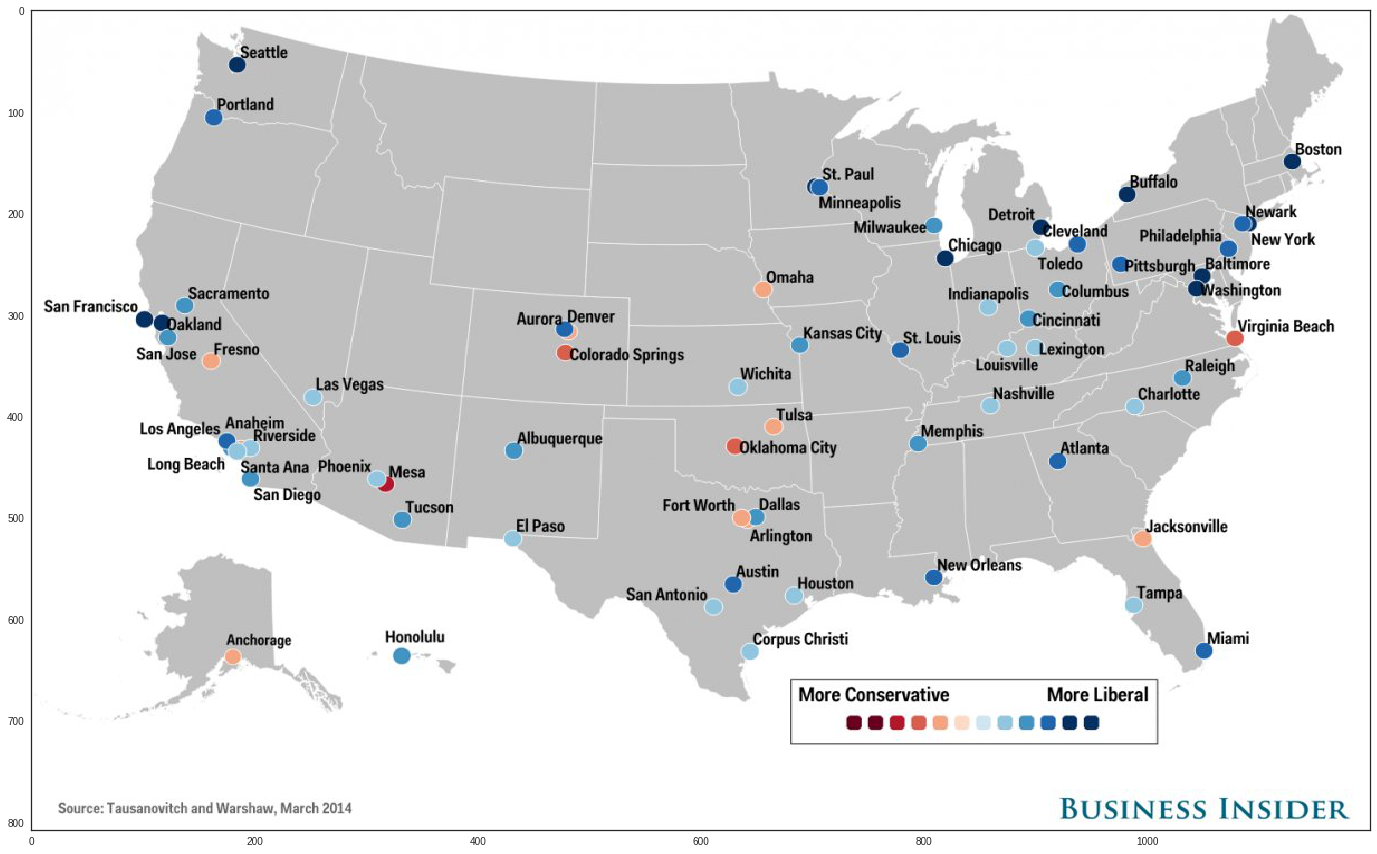

In [36]:
img = plt.imread('../plots/major_cities.jpg'); plt.figure(figsize=(24,18))
plt.imshow(img,interpolation='none',aspect=1.35*(808./1200))

## Added headcount to plot using the size of the points
* Smaller points mean less headcount. Larger mean more
* Once again, the major cities stand out
* However, notice the spread of pink dots shrink in relation to the green dots, especially in the dense areas
* This means that businesses in the green range (\$2.5Mto \$100M) typically have more employees than businesses in the pink range (Over \$100M)

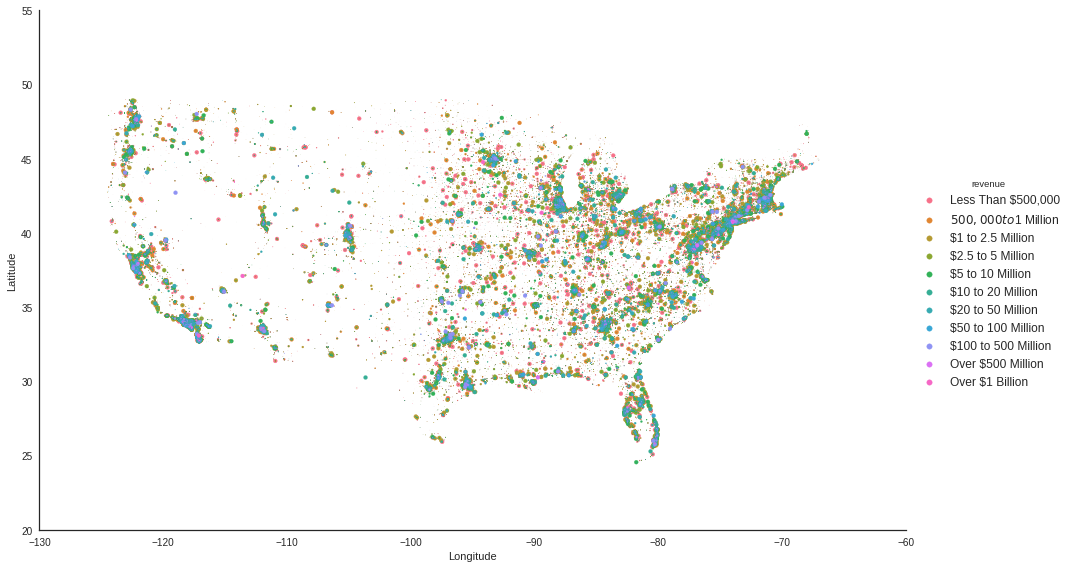

In [37]:
hdcnt = big_df.hdcnt_n[big_df.rev_n>-1]
si_hdcnt = (hdcnt/(hdcnt.max()-hdcnt.min()))**2   # Normalize to [0,1]

fg = sns.FacetGrid(data=data, hue=color_column, hue_order=rev_order,size=8, aspect=1.61,xlim=(-130,-60),ylim=(20,55))
_ = fg.map(plt.scatter, 'Longitude', 'Latitude',s=(si_hdcnt*15)).add_legend(fontsize='large',markerscale=2.0)

## NAICS codes
  * First 2 digits indicate sector, 3rd is subsector, 4th is industry group, 5th and 6th are specific industries
    * I referenced the code descriptions using following data from NAICS: https://www.census.gov/eos/www/naics/downloadables/downloadables.html
    * All the 2-digit sectors matched with the offical NAICS codes but lots of 3-6 digit codes did not

In [38]:
naics = pd.read_excel('../supp_data/2-6 digit_2017_Codes.xlsx')
hlpr.join_naics_desc(big_df, naics, return_non_match_cnt=True)

,num_non_matches
naics_sector_desc,0
naics_subsector_desc,190414
naics_industry_grp_desc,350089
naics_industries_5_desc,605680
naics_industries_6_desc,694956


## Split USA into 9 divisions/regions
* Pacific, Mountain, West North Central (WNC), WSC, ESC, ENC, South Atlantic, Middle Atlantic and New England
* StatisticalAtlas.com shows NAICS codes analysis for various regions of the US
    * https://statisticalatlas.com/United-States/Overview
* One of the ways they split geographically is Divisions (Mountain, SouthAtlantic, Pacific..) - Loosely similar to timezones
* They have approx 140 Million records and they show several plots using the same 20 NAICS sectors as we have

In [39]:
all_divisions, states = hlpr.make_USA_divisions(big_df, states_df=True)  # returns list of Regions class objects
states

,0,1,2,3,4,5,6,7
mountain,MT,ID,WY,NV,UT,CO,AZ,NM
southatlantic,WV,MD,DE,VA,NC,SC,GA,FL
middleatlantic,PA,NJ,NY,None,None,None,None,None
eastsouthcentral,KY,TN,AL,MS,None,None,None,None
newengland,ME,VT,NH,MA,RI,CT,None,None
westsouthcentral,OK,TX,AK,LA,None,None,None,None
westnorthcentral,IA,KS,MN,MO,NE,ND,SD,None
pacific,AK,WA,OR,CA,None,None,None,None
eastnorthcentral,WI,MI,IL,IN,OH,None,None,None


## Different results than StatisticalAtlas
* StatisticalAtlas has 140 million records. My dataset has only 1 million.
* See below for overall US percentages per sector. Mine and StatAtlas' are different
    * This is likely due to random sampling to obtain our dataset

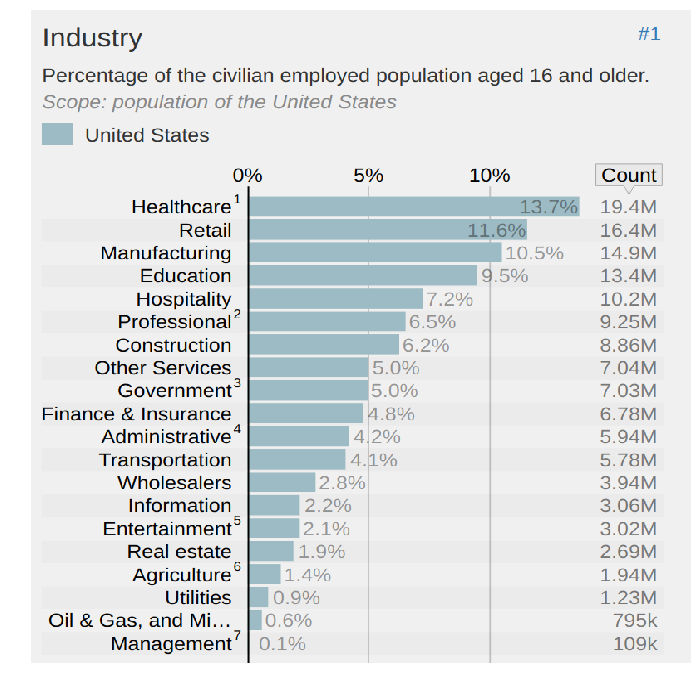

In [40]:
img = plt.imread('../plots/Industries.png'); plt.figure(figsize=(16,12)); plt.axis('off')
_ = plt.imshow(img,interpolation='none',aspect=1.35*(808./1200))

In [41]:
big_df.naics_sector_desc.value_counts()*1./len(big_df)

Professional, Scientific, and Technical Services                            0.160855
Retail Trade                                                                0.107721
Health Care and Social Assistance                                           0.105475
Other Services (except Public Administration)                               0.097738
Construction                                                                0.079267
Finance and Insurance                                                       0.078129
Real Estate and Rental and Leasing                                          0.060704
Educational Services                                                        0.058988
Wholesale Trade                                                             0.054756
Administrative and Support and Waste Management and Remediation Services    0.046201
Manufacturing                                                               0.045423
Accommodation and Food Services                                  

## Relative Industry Plots
* For each sector, I normalized Industry count by the region and subracted the overall US sector count
* This nuances the subtle differences between regions' industry sectors
* StatsAtlas' relative industry plot is shown for one of the divisions, Mountain
    * Compared to my 1st barplot below (for Mountain), the heirarchy of the sectors is noticeably different once again
    * Upon further checking, each of the regions' top sectors came out differently from StatAtlas'
    * I suspect that this is once again due to my data being a small random sample of the dataset StatsAtlas has
    * However, the data as it stands now suggests that the West South Central, which consists of TX, OK, AK, and Louisiana, has more businesses in Construction and Wholesale trade compared to the rest of the nation. Having lived in Texas for over 10 years, this sounds reasonable to me.
    * The top industries per region and its associated states are shown below

MOUNTAIN region/division


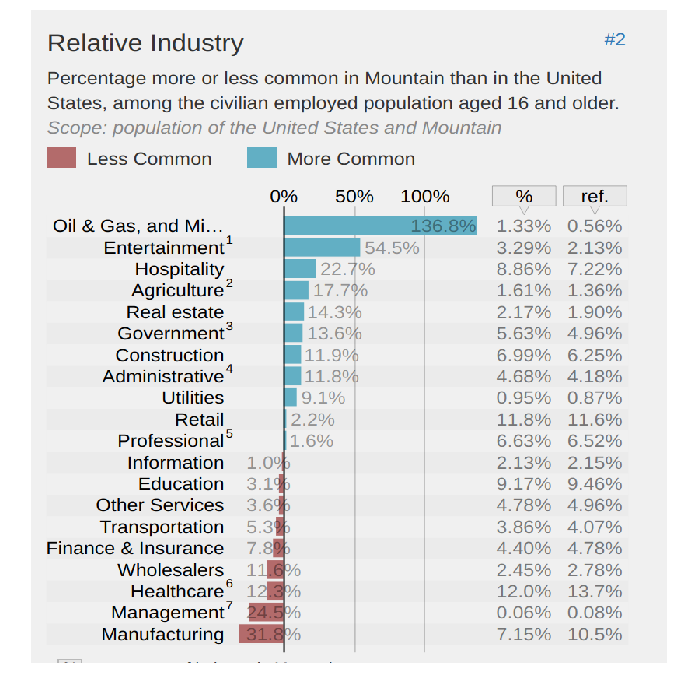

In [42]:
img = plt.imread('../plots/Mountain_industries.png'); plt.figure(figsize=(16,12)); plt.axis('off')
_ = plt.imshow(img,interpolation='none',aspect=1.35*(808./1200))
print "MOUNTAIN region/division" #https://statisticalatlas.com/division/Mountain/Industries

In [43]:
col = 'naics_sector_desc'

MOUNTAIN
['MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM']


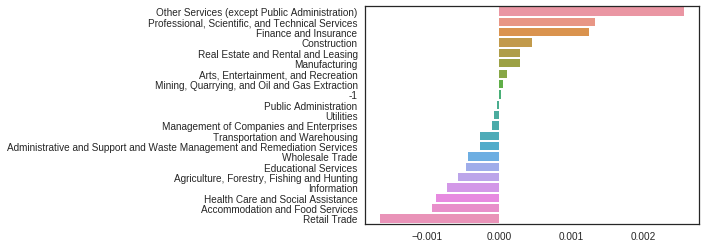



SOUTHATLANTIC
['WV', 'MD', 'DE', 'VA', 'NC', 'SC', 'GA', 'FL']


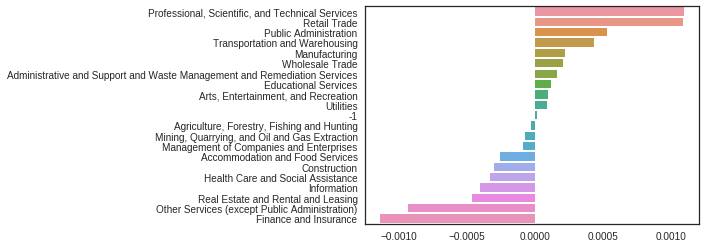



MIDDLEATLANTIC
['PA', 'NJ', 'NY']


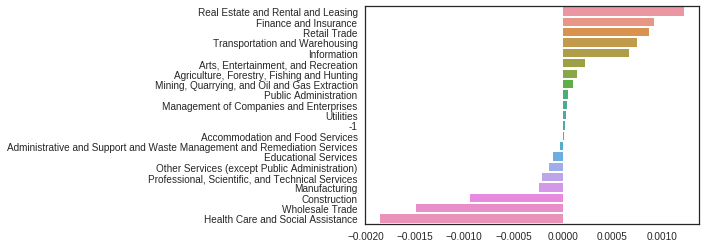



EASTSOUTHCENTRAL
['KY', 'TN', 'AL', 'MS']


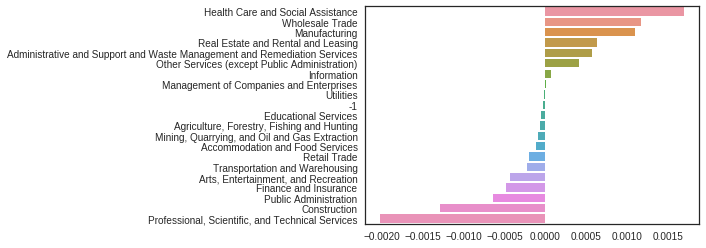



NEWENGLAND
['ME', 'VT', 'NH', 'MA', 'RI', 'CT']


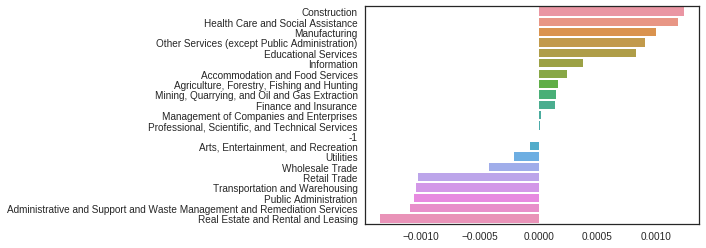



WESTSOUTHCENTRAL
['OK', 'TX', 'AK', 'LA']


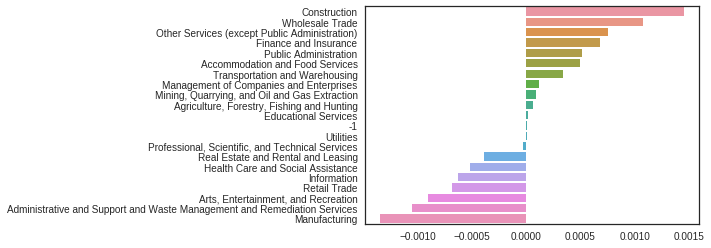



WESTNORTHCENTRAL
['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']


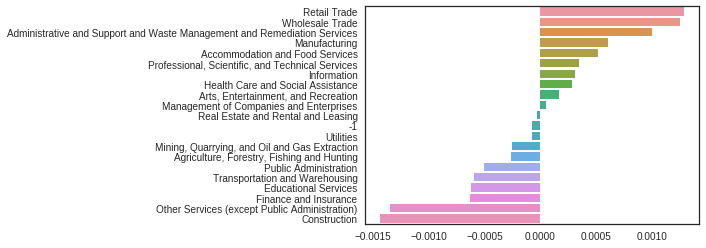



PACIFIC
['AK', 'WA', 'OR', 'CA']


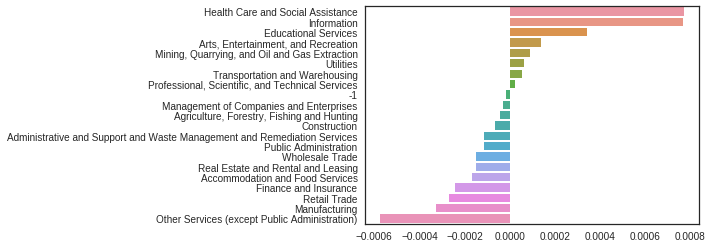



EASTNORTHCENTRAL
['WI', 'MI', 'IL', 'IN', 'OH']


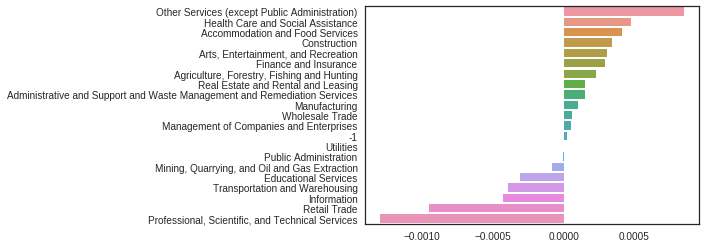

In [59]:
i = 0
for division in all_divisions:
    print division.name.upper()
    print [x for x in list(states.iloc[i]) if x!=None]; i+=1
    relative_percentages = hlpr.common_industries(big_df,division,col)
    _ = sns.barplot(relative_percentages.values,relative_percentages.index)
    plt.show()
    print '\n'

### More to come in the future